# Продвинутые Свёрточные Нейронные Сети. Часть 2. 
# Transfer Learning

## Переключение версии TensorFlow

In [ ]:
%tensorflow_version 2.x

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.models import load_model

## Загрузка датасета Food 101

In [12]:
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

get_data_extract()

Dataset already exists


## Визуализация датасета Food 101

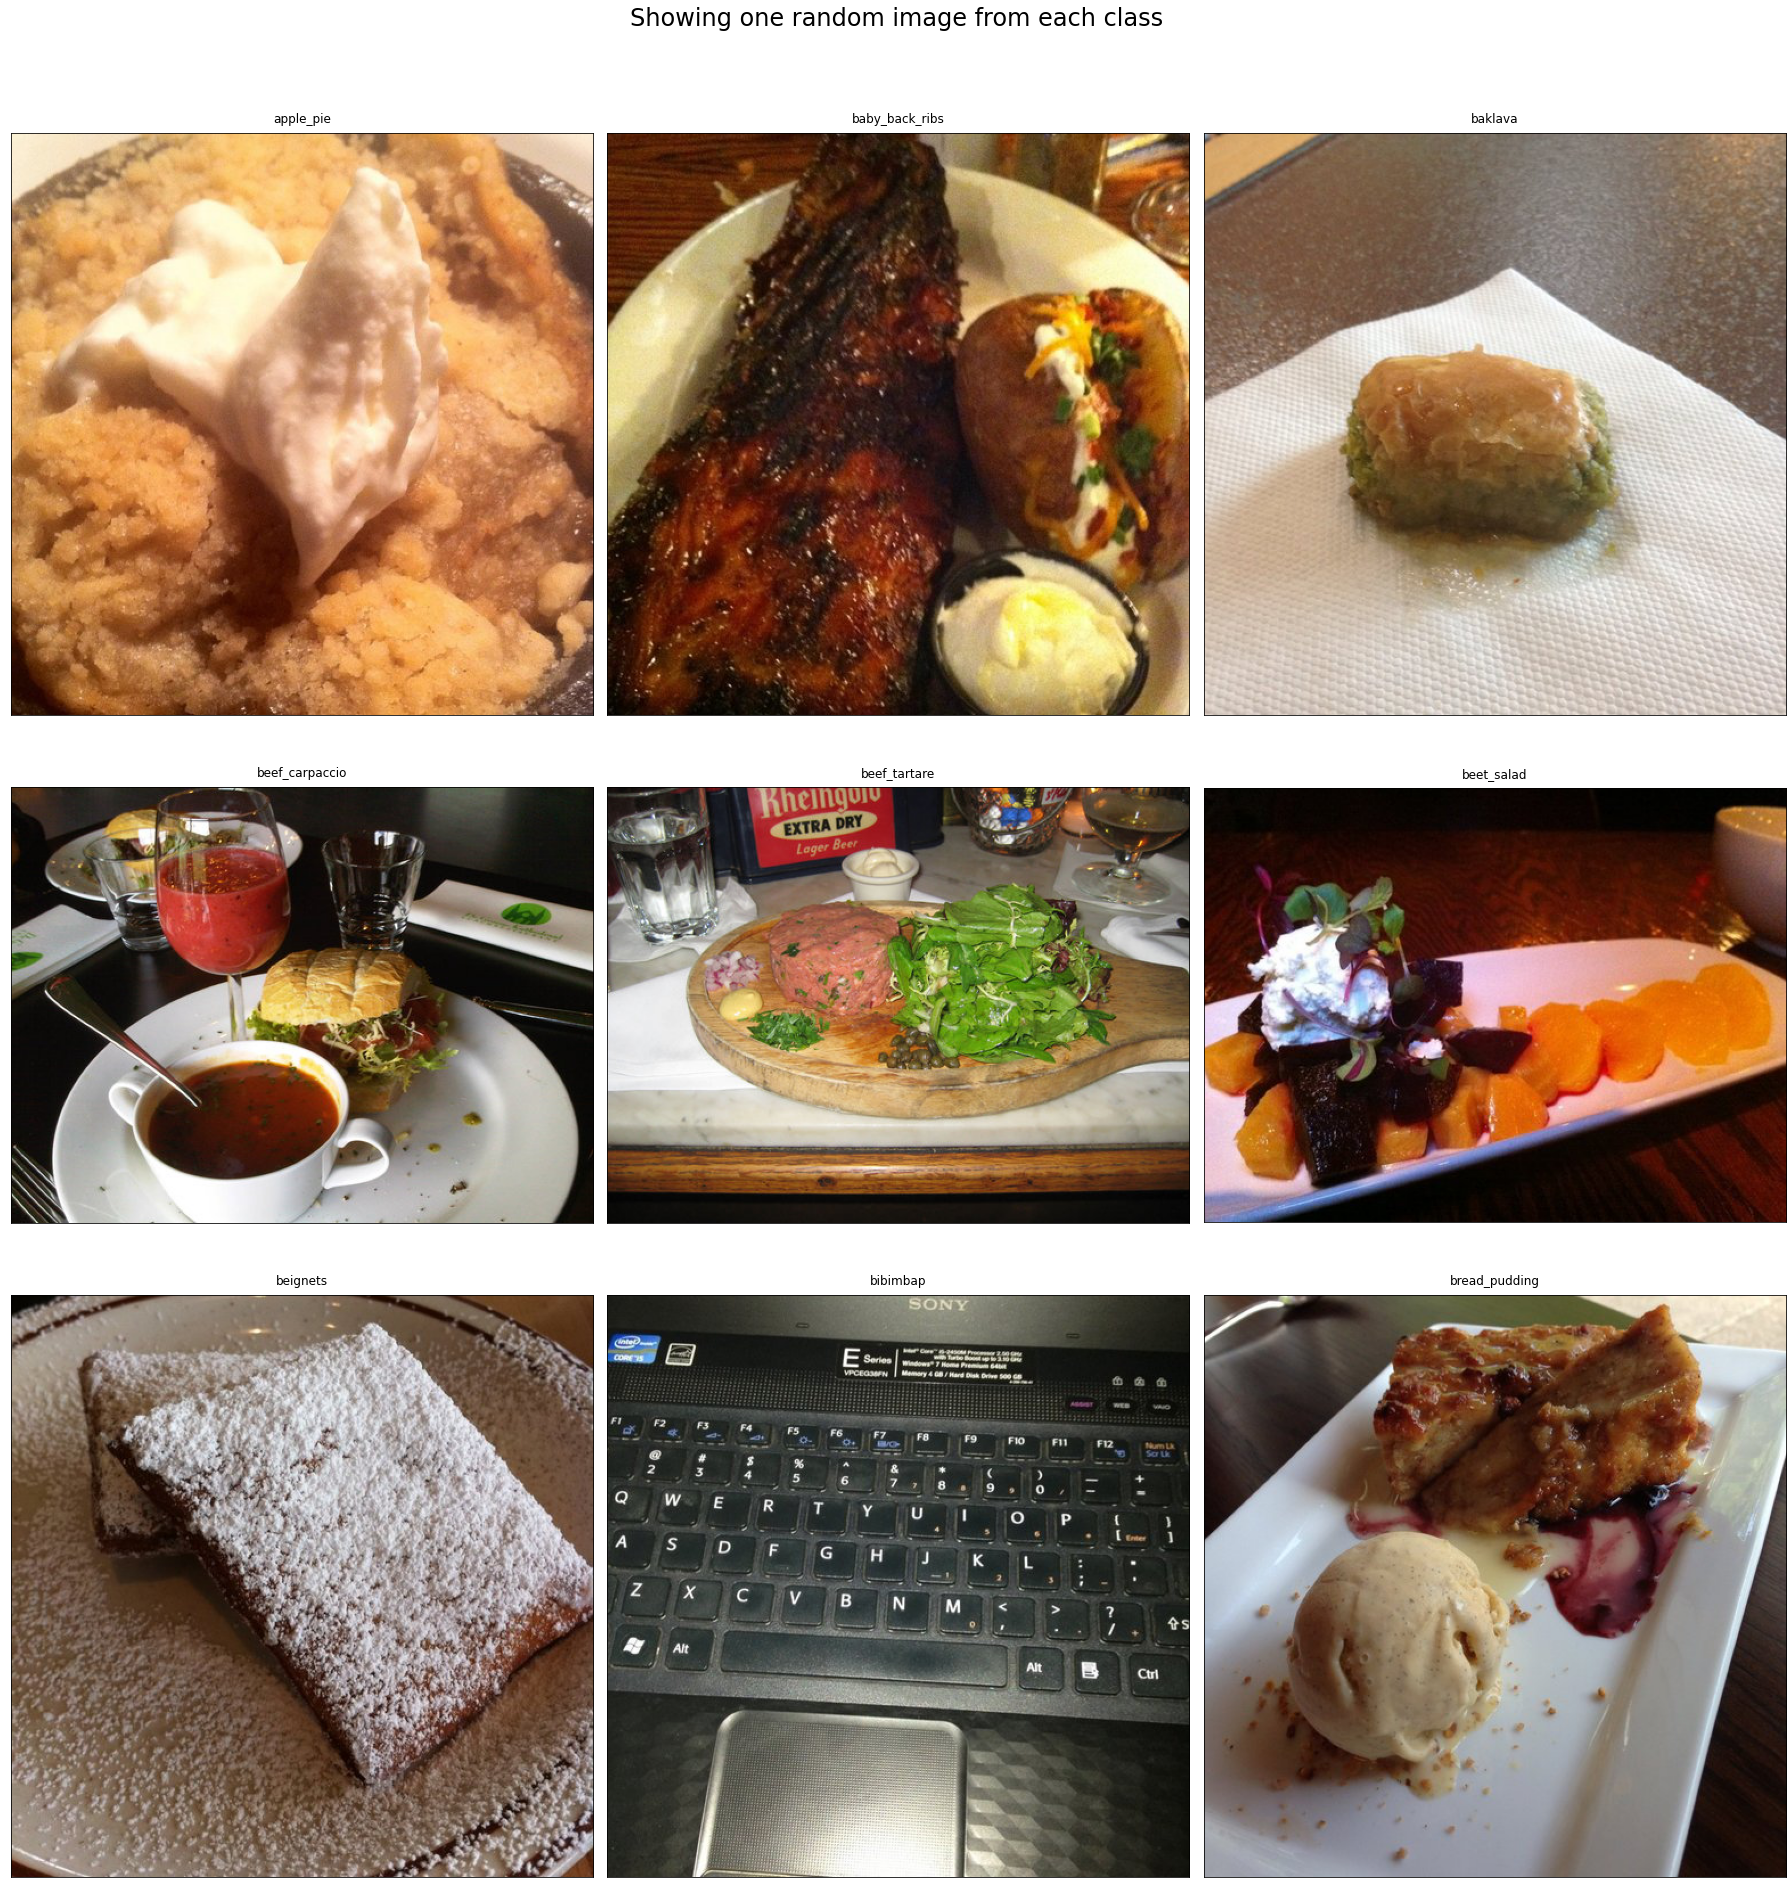

In [13]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

## Создание пайплайна данных

In [14]:
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [15]:
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating train data...
Copying Done!
Creating test data...
Copying Done!


In [16]:
INP_SIZE = 224
INP_SHAPE = (INP_SIZE, INP_SIZE, 3)
NUM_EPOCHS = 10
BATCH_SIZE = 128
NUM_CLASSES = 101

train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=30,
  shear_range=0.3,
  horizontal_flip=True,
  width_shift_range=0.1,
  height_shift_range=0.1,
  zoom_range=0.25,
)
valid_datagen = ImageDataGenerator(
  rescale=1./255,
)

In [17]:
train_data = train_datagen.flow_from_directory(
    'food-101/train/',
    batch_size=BATCH_SIZE,
    target_size=(INP_SIZE, INP_SIZE),
    shuffle=True,
)
valid_data = valid_datagen.flow_from_directory(
    'food-101/test/',
    target_size=(INP_SIZE, INP_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


# Подготовка модели #1 CNN

In [18]:
EXP_NAME = 'model #1'

base = MobileNetV2(input_shape=INP_SHAPE,include_top=False,weights='imagenet')
base.trainable = True
model_1 = Sequential()
model_1.add(base)
model_1.add(GlobalAveragePooling2D())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(NUM_CLASSES, activation='softmax'))
model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 101)               13029     
                                                                 
Total params: 2,434,981
Trainable params: 2,400,869
No

## Обучение модели #1

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
  log_dir='logs/'+EXP_NAME, 
  write_graph=False, update_freq=100, profile_batch=0)

early_stop = EarlyStopping(monitor = 'val_accuracy',patience = 5,verbose = 1,restore_best_weights = True)

history = model_1.fit(
    train_data,
    epochs=NUM_EPOCHS,
    validation_data=valid_data,
    callbacks=[early_stop, tensorboard_callback])

model_1.evaluate(test_ds)

# Подготовка модели #2 CNN

In [19]:
EXP_NAME = 'model #2'

base = MobileNetV2(input_shape=INP_SHAPE,include_top=False,weights='imagenet')
base.trainable = True
model_2 = Sequential()
model_2.add(base)
model_2.add(GlobalAveragePooling2D())
model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(101, activation='softmax'))
model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dropout_3 (Dropout)         (None, 128)              

## Обучение модели #2

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
  log_dir='logs/'+EXP_NAME, 
  write_graph=False, update_freq=100, profile_batch=0)

early_stop = EarlyStopping(monitor = 'val_accuracy',patience = 5,verbose = 1,restore_best_weights = True)

history = model_2.fit(
    train_data,
    epochs=NUM_EPOCHS,
    validation_data=valid_data,
    callbacks=[early_stop, tensorboard_callback])

model_2.evaluate(test_ds)

## TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

## Запуск предсказания на нашем изображении

--2021-12-05 18:37:43--  https://eda.ru/img/eda/c620x415/s1.eda.ru/StaticContent/Photos/120131085053/171027192707/p_O.jpg
Resolving eda.ru (eda.ru)... 81.19.92.116
Connecting to eda.ru (eda.ru)|81.19.92.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121994 (119K) [image/jpeg]
Saving to: ‘p_O.jpg’

p_O.jpg             100%[===================>] 119.13K   356KB/s    in 0.3s    

2021-12-05 18:37:45 (356 KB/s) - ‘p_O.jpg’ saved [121994/121994]



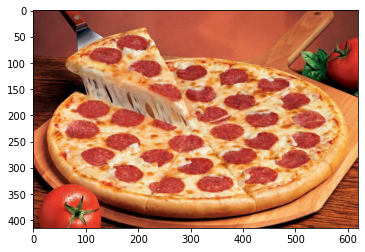

In [20]:
import imageio
from skimage.transform import resize

def prepare_image(img):
    img = img.astype(np.float32)/127. - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

if 1:
    !wget https://eda.ru/img/eda/c620x415/s1.eda.ru/StaticContent/Photos/120131085053/171027192707/p_O.jpg

img = imageio.imread('p_O.jpg', pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)

In [ ]:
pred_1 = model_1(img[None, ...], training=False)
pred_2 = model_2(img[None, ...], training=False)

pred_label_1 = int(pred_1.numpy()[0][0] > 0.5)
pred_label_2 = int(pred_2.numpy()[0][0] > 0.5)

# print('Prediction model #1: {}'.format(ds_info.features['label'].int2str(pred_label)))
# print('Prediction model #2: {}'.format(ds_info.features['label'].int2str(pred_label)))